In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import math
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM


import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Loading Data**

In [2]:
submission = pd.read_csv('/kaggle/input/playground-series-s3e21/sample_submission.csv')
df = submission.copy()

submission.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,9.545,9.265,8.110,8.43,7.15,0.180,0.200,0.650,14.515,5.845,1.285,0.429,0.030,0.050,0.064,0.730,1.075,0.056,0.567,0.400,1.500,1.560,19.355,4.95,1.730,1.800,4.800,3.15,10.665,10.465,16.645,5.75,10.37
1,1,9.10,13.533,40.90,8.770,9.265,6.015,10.07,7.15,1.107,1.027,1.848,8.625,12.175,0.280,0.440,0.089,1.360,0.064,0.902,1.454,0.056,0.190,2.347,5.105,2.095,19.355,20.05,9.530,7.695,4.550,6.95,2.040,5.200,5.725,2.95,2.23
2,2,8.21,3.710,5.42,8.770,9.265,4.550,10.07,7.15,0.020,0.020,0.650,17.144,24.645,0.380,0.440,0.060,0.050,0.082,0.902,2.025,0.056,0.567,1.700,1.700,3.960,4.900,4.58,3.025,3.960,4.935,4.95,4.725,6.075,6.750,3.50,3.17
3,3,8.39,8.700,8.10,9.500,9.200,5.200,8.67,6.67,0.280,0.270,1.730,3.870,8.410,1.480,1.380,0.050,0.050,0.070,0.530,1.740,0.050,0.064,1.500,1.500,2.020,3.960,8.45,2.070,1.730,6.300,4.70,3.500,6.200,8.670,2.90,7.37
4,4,8.07,8.050,8.65,7.960,9.265,3.290,10.07,7.15,0.360,0.435,0.650,3.850,5.845,0.280,0.440,0.105,0.115,0.074,1.252,1.075,0.071,0.190,1.050,1.150,2.095,3.902,2.02,1.730,0.760,4.800,4.97,3.950,2.800,8.400,3.50,3.90


**EDA Basic**

In [3]:
submission.describe().T\
    .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
    .background_gradient(subset=['std'], cmap='Blues')\
    .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
id,3500.000000,1749.500000,1010.507298,0.000000,874.750000,1749.500000,2624.250000,3499.000000
target,3500.000000,8.473834,1.885712,1.300000,7.470000,8.280000,9.110000,65.930000
O2_1,3500.000000,8.216993,3.040743,0.000000,7.100000,7.890000,9.100000,46.950000
O2_2,3500.000000,9.291581,6.817822,0.000000,7.300000,8.300000,8.700000,65.950000
O2_3,3500.000000,9.633064,1.439039,4.900000,8.770000,9.500000,9.545000,16.900000
O2_4,3500.000000,8.065733,1.463881,2.300000,6.830000,7.980000,9.265000,21.800000
O2_5,3500.000000,5.671581,2.721399,0.200000,4.550000,5.800000,7.015000,59.400000
O2_6,3500.000000,9.461363,1.140365,0.000000,8.980000,9.430000,10.070000,40.190000
O2_7,3500.000000,6.547433,1.663266,0.000000,5.877500,6.430000,7.150000,15.900000
NH4_1,3500.000000,0.340525,0.284751,0.020000,0.214500,0.247000,0.370000,4.200000


In [4]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum().values*100
    sum['missing%'] = (df.isna().sum().values*100)/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    sum['skew'] = df.skew().values
    desc = pd.DataFrame(df.describe().T)
    sum['min'] = desc['min']
    sum['max'] = desc['max']
    sum['mean'] = desc['mean']
    return sum

summary(submission).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count,skew,min,max,mean
id,int64,0,0.000000,3500,3500,0.000000,0.000000,3499.000000,1749.500000
target,float64,0,0.000000,462,3500,10.460854,1.300000,65.930000,8.473834
O2_1,float64,0,0.000000,329,3500,7.753354,0.000000,46.950000,8.216993
O2_2,float64,0,0.000000,258,3500,4.314217,0.000000,65.950000,9.291581
O2_3,float64,0,0.000000,235,3500,1.254857,4.900000,16.900000,9.633064
O2_4,float64,0,0.000000,241,3500,0.782568,2.300000,21.800000,8.065733
O2_5,float64,0,0.000000,317,3500,3.740421,0.200000,59.400000,5.671581
O2_6,float64,0,0.000000,238,3500,5.246618,0.000000,40.190000,9.461363
O2_7,float64,0,0.000000,303,3500,0.285303,0.000000,15.900000,6.547433
NH4_1,float64,0,0.000000,152,3500,3.237432,0.020000,4.200000,0.340525


In [5]:
target = 'target'
num_var = submission.columns.drop(['target','id'])

<Figure size 1000x800 with 0 Axes>

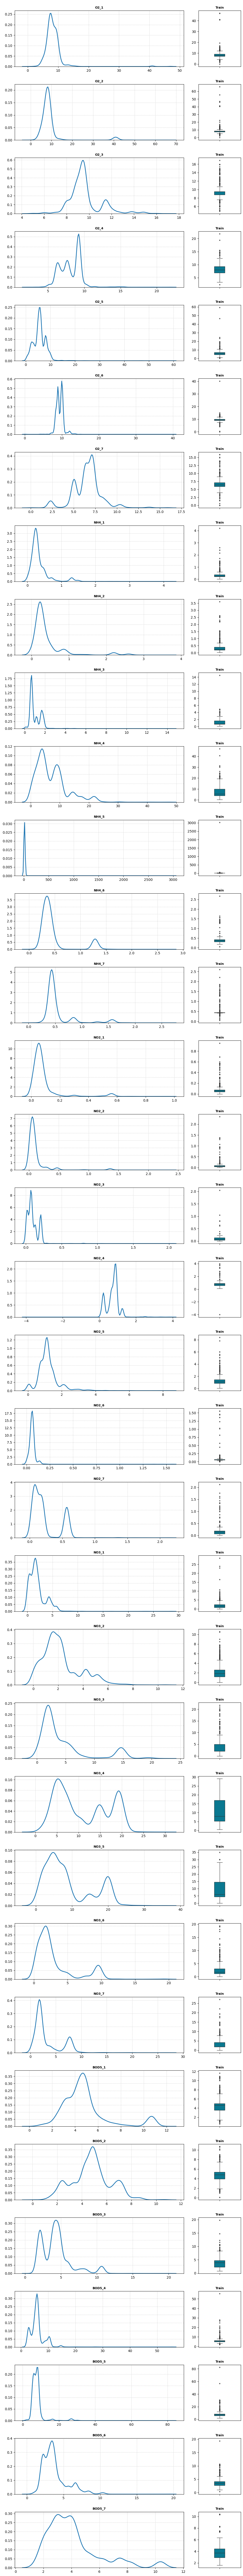

In [6]:
plt.figure(figsize=(10, 8));
fig, axes = plt.subplots(len(num_var), 2 ,figsize=(10, len(num_var) * 3), gridspec_kw={'width_ratios': [4, 1]});

for i,col in enumerate(num_var):
    ax = axes[i,0];
    sns.kdeplot(data = submission, x = col, ax = ax, linewidth = 2.1)
    ax.set_title(f"\n{col}",fontsize = 9, fontweight= 'bold');
    ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75);
    ax.set(xlabel = '', ylabel = '');

    ax = axes[i,1];
    sns.boxplot(data = submission, y = col, width = 0.25,saturation = 0.90, linewidth = 0.90, fliersize= 2.25, color = '#037d97',
                ax = ax);
    ax.set(xlabel = '', ylabel = '');
    ax.set_title(f"Train",fontsize = 9, fontweight= 'bold');

plt.tight_layout();
plt.show();

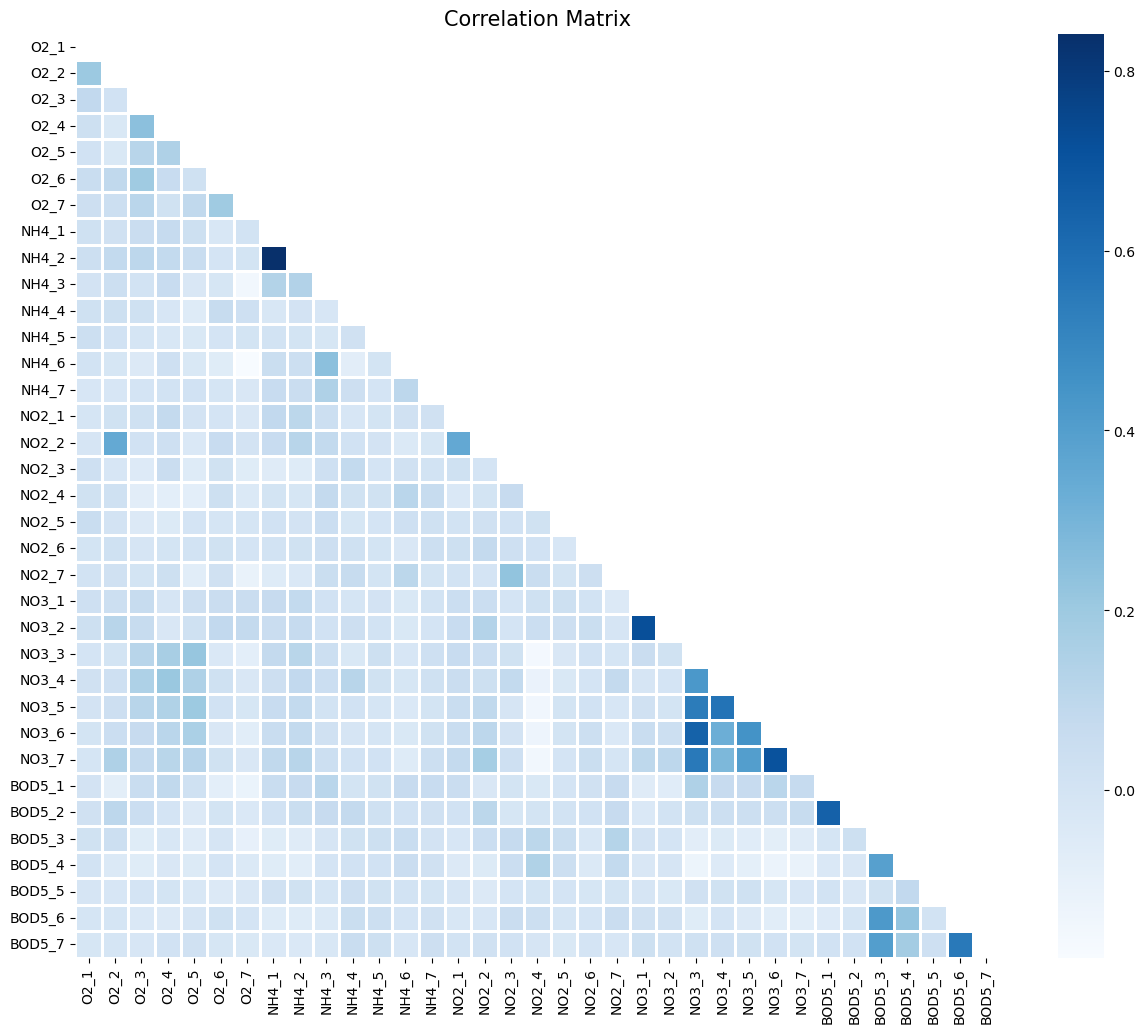

In [7]:
corr_matrix = submission[num_var].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9} )
plt.title('Correlation Matrix', fontsize=15)
plt.show()

**Baseline**

In [8]:
rf = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)

mse_results = pd.DataFrame(columns=['Selected_Features', 'MSE'])

def evaluation(df,select_features,note):
    global mse_results
    
    X = df[select_features]
    Y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)
    rf.fit(X_train, y_train)
    y_hat = rf.predict(X_test) 
    mse =  mean_squared_error(y_test, y_hat)
    mse_results = mse_results.append({'Selected_Features': note, 'MSE': mse}, ignore_index=True)
    
    print('====================================')
    print(note)
    print("MSE:", mse)
    print('====================================')

In [9]:
# baseline evaluation

evaluation(df=submission,select_features=num_var,note='Baseline')

Baseline
MSE: 1.3008160325406115


In [10]:
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

vif_results = calculate_vif(submission[num_var])
print(vif_results)

   Feature        VIF
0     O2_1   8.840503
1     O2_2   3.697835
2     O2_3  48.340716
3     O2_4  33.434847
4     O2_5   5.911990
5     O2_6  58.198607
6     O2_7  18.011732
7    NH4_1   8.490727
8    NH4_2   6.343775
9    NH4_3   4.575890
10   NH4_4   2.971221
11   NH4_5   1.094900
12   NH4_6   3.633986
13   NH4_7   4.677865
14   NO2_1   1.897085
15   NO2_2   1.884845
16   NO2_3   2.591047
17   NO2_4   5.601847
18   NO2_5   4.503123
19   NO2_6   1.768148
20   NO2_7   2.423107
21   NO3_1   4.946205
22   NO3_2   6.833076
23   NO3_3   4.362984
24   NO3_4   7.051944
25   NO3_5   5.298075
26   NO3_6   5.158091
27   NO3_7   5.448053
28  BOD5_1  13.144511
29  BOD5_2  19.394173
30  BOD5_3   7.756715
31  BOD5_4   7.759643
32  BOD5_5   5.354107
33  BOD5_6   9.447174
34  BOD5_7   8.772270


In [11]:
vif15_features = vif_results[vif_results['VIF']<15]['Feature'].tolist() # VIF values below 15.
vif10_features = vif_results[vif_results['VIF']<10]['Feature'].tolist() # VIF values below 10.
vif5_features = vif_results[vif_results['VIF']<5]['Feature'].tolist() # VIF values below 5.

In [12]:
evaluation(df=submission,select_features=vif5_features,note='VIF < 5')
evaluation(df=submission,select_features=vif10_features,note='VIF < 10')
evaluation(df=submission,select_features=vif15_features,note='VIF < 15')

VIF < 5
MSE: 2.2565205326402826
VIF < 10
MSE: 1.30421796935493
VIF < 15
MSE: 1.3069967221275343


**Feature information**

In [13]:
def f_importance_plot(f_imp):
    fig = plt.figure(figsize=(12, 0.20*len(f_imp)))
    plt.title(f'Feature importances', size=16, y=1.05, 
              fontweight='bold')
    a = sns.barplot(data=f_imp, x='imp', y='feature', linestyle="-", 
                    linewidth=0.5, edgecolor="black",palette='GnBu')
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11)
    
    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)
    for j in ['left']:
        a.spines[j].set_linewidth(0.5)
    plt.tight_layout()
    plt.show()

In [14]:
rf.fit(submission[num_var],submission[target])

RandomForestRegressor(max_depth=7, n_estimators=1000, n_jobs=-1,
                      random_state=42)

In [15]:
f_imp_df = pd.DataFrame({'feature': num_var, 'imp': rf.feature_importances_})
f_imp_df.sort_values(by='imp',ascending=False,inplace=True)

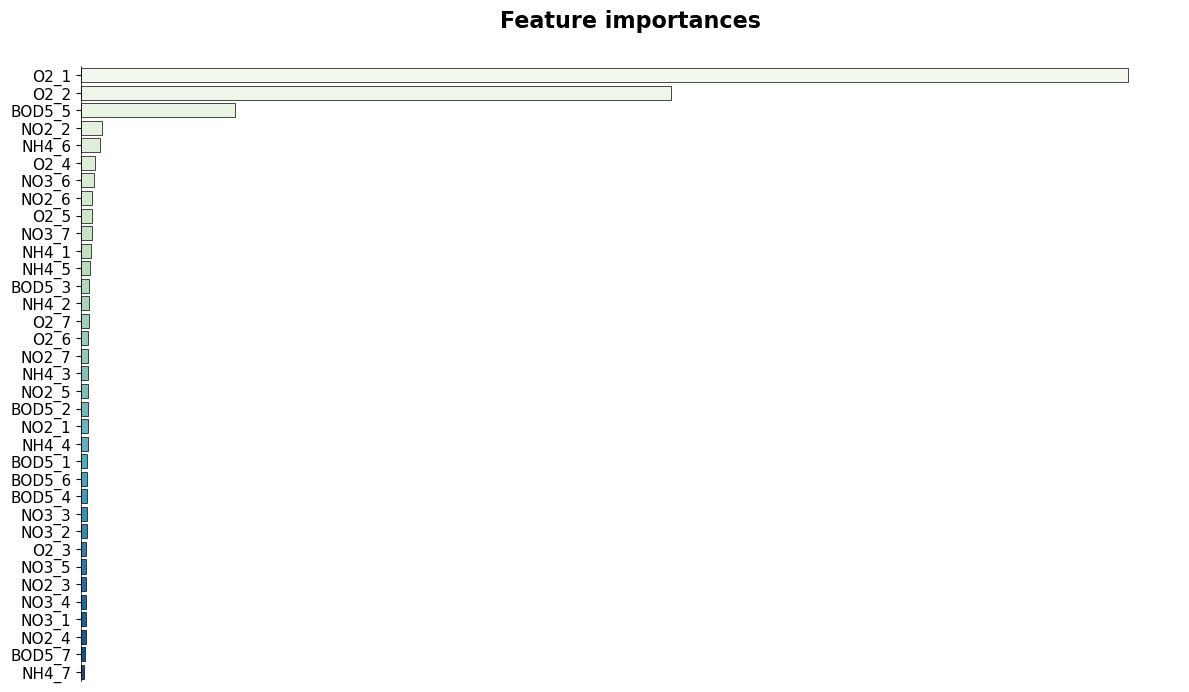

In [16]:
f_importance_plot(f_imp_df)

In [17]:
top3rf_features = f_imp_df.head(3).feature.to_list()
top4rf_features = f_imp_df.head(4).feature.to_list()

evaluation(df=submission,select_features=top3rf_features,note='Top 3 Features')
evaluation(df=submission,select_features=top4rf_features,note='Top 4 Features')

Top 3 Features
MSE: 1.3839898138065372
Top 4 Features
MSE: 1.2949318908291982


**Preprocessing Data**

In [18]:
submission = submission[submission['id'] != 2365]

evaluation(df=submission,select_features=top4rf_features,note='Trick + Top 4 Features')
evaluation(df=submission,select_features=top3rf_features,note='Trick + Top 3 Features')

Trick + Top 4 Features
MSE: 1.1333427332771293
Trick + Top 3 Features
MSE: 1.216463434965139


[7, 20] and [7, 35] are proved to be good cutoff points. After Version 7, I skipped its calculation process, but still kept the code for anyone who needs to see it.

The conclusions for clips come from this notebook.

In [19]:
def search_best_cutoff(df,bot_cutoff,top_cutoff):
    X = df.drop(target,axis=1)
    Y = df[target].clip(bot_cutoff,top_cutoff)
    
    for column in X.columns:
        if column not in ['O2_1','O2_2','BOD5_5']:
            X[column] = 0
        
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)
    rf = RandomForestRegressor(n_estimators=1000,max_depth=7,n_jobs=-1,random_state=42)
    rf.fit(X_train, y_train)
    y_hat = rf.predict(X_test) 
    mse =  mean_squared_error(y_test, y_hat)
    return mse
    print("MSE:", mse)

In [20]:
submission7_20 = submission.copy()
submission7_20.target = submission7_20.target.clip(7, 20)

submission7_35 = submission.copy()
submission7_35.target = submission7_35.target.clip(7, 35)


In [21]:
#print(Fore.YELLOW + f'=============Clip(7_20)==============' + Style.RESET_ALL)
evaluation(df=submission7_20,select_features=top4rf_features,note='Clip(7,20) + Top 4 Features')
evaluation(df=submission7_20,select_features=top3rf_features,note='Clip(7,20) + Top 3 Features')

#print(Fore.YELLOW + f'=============Clip(7_35)==============' + Style.RESET_ALL)
evaluation(df=submission7_35,select_features=top4rf_features,note='Clip(7,35) + Top 4 Features')
evaluation(df=submission7_35,select_features=top3rf_features,note='Clip(7,35) + Top 3 Features')

Clip(7,20) + Top 4 Features
MSE: 1.0069962929813279
Clip(7,20) + Top 3 Features
MSE: 1.1099259719170953
Clip(7,35) + Top 4 Features
MSE: 0.9852990651810758
Clip(7,35) + Top 3 Features
MSE: 1.085484295138602


**SGDOneClassSVM**

In [22]:
submission7_20_sgd = submission7_20.copy()
clf = SGDOneClassSVM(nu=0.55).fit(submission7_20_sgd.drop(['id'],axis=1))

# Drop outliers
submission7_20_sgd.drop(np.array(np.where(clf.predict(submission7_20_sgd.drop(['id'],axis=1))==-1))[0], axis=0, inplace=True)
submission7_20_sgd = submission7_20_sgd.reset_index(drop=True)


# Clip 7_35 + SGD
submission7_35_sgd = submission7_35.copy()
clf = SGDOneClassSVM(nu=0.55).fit(submission7_35_sgd.drop(['id'],axis=1))

# Drop outliers
submission7_35_sgd.drop(np.array(np.where(clf.predict(submission7_35_sgd.drop(['id'],axis=1))==-1))[0], axis=0, inplace=True)
submission7_35_sgd = submission7_35_sgd.reset_index(drop=True)

In [23]:
#print(YELLOW + f'=============Clip(7_20)==============' + Style.RESET_ALL)
evaluation(df=submission7_20_sgd,select_features=top4rf_features,note='Clip(7,20) + SGD + Top 4 Features')
evaluation(df=submission7_20_sgd,select_features=top3rf_features,note='Clip(7,20) + SGD + Top 3 Features')

#print(YELLOW + f'=============Clip(7_35)==============' + Style.RESET_ALL)
evaluation(df=submission7_35_sgd,select_features=top4rf_features,note='Clip(7,35) + SGD + Top 4 Features')
evaluation(df=submission7_35_sgd,select_features=top3rf_features,note='Clip(7,35) + SGD + Top 3 Features')

Clip(7,20) + SGD + Top 4 Features
MSE: 0.8878170631078188
Clip(7,20) + SGD + Top 3 Features
MSE: 0.9033345775929913
Clip(7,35) + SGD + Top 4 Features
MSE: 1.8752699459793558
Clip(7,35) + SGD + Top 3 Features
MSE: 1.8747077101044192


In [24]:
submission7_20_if = submission7_20.copy()
clf = IsolationForest(random_state=0).fit(submission7_20_if.drop(['id'],axis=1))
submission7_20_if.drop(np.array(np.where(clf.predict(submission7_20_if.drop(['id'],axis=1))==-1))[0], axis=0, inplace=True)

In [25]:
submission7_35_if = submission7_35.copy()
clf = IsolationForest(random_state=0).fit(submission7_35_if.drop(['id'],axis=1))
submission7_35_if.drop(np.array(np.where(clf.predict(submission7_35_if.drop(['id'],axis=1))==-1))[0], axis=0, inplace=True)

In [26]:
#print(Fore.YELLOW + f'=============Clip(7_20)==============' + Style.RESET_ALL)
evaluation(df=submission7_20_if,select_features=top4rf_features,note='Clip(7,20) + IF + Top 4 Features')
evaluation(df=submission7_20_if,select_features=top3rf_features,note='Clip(7,20) + IF + Top 3 Features')

#print(Fore.YELLOW + f'=============Clip(7_35)==============' + Style.RESET_ALL)
evaluation(df=submission7_35_if,select_features=top4rf_features,note='Clip(7,35) + IF + Top 4 Features')
evaluation(df=submission7_35_if,select_features=top3rf_features,note='Clip(7,35) + IF + Top 3 Features')

Clip(7,20) + IF + Top 4 Features
MSE: 1.0261411775263438
Clip(7,20) + IF + Top 3 Features
MSE: 1.0395443477619601
Clip(7,35) + IF + Top 4 Features
MSE: 2.120734196998219
Clip(7,35) + IF + Top 3 Features
MSE: 2.1493855147567453


**LocalOutlierFactor**

In [27]:
submission7_20_lof = submission7_20.copy()
lof = LocalOutlierFactor(n_neighbors=3, contamination=0.1)
outlier_predictions = lof.fit_predict(submission7_20_lof[num_var])
outliers_indices = np.where(outlier_predictions == -1)[0]
submission7_20_lof.drop(outliers_indices, axis=0, inplace=True)

In [28]:
submission7_35_lof = submission7_35.copy()
lof = LocalOutlierFactor(n_neighbors=3, contamination=0.1)
outlier_predictions = lof.fit_predict(submission7_35_lof[num_var])
outliers_indices = np.where(outlier_predictions == -1)[0]
submission7_35_lof.drop(outliers_indices, axis=0, inplace=True)

In [29]:
#print(Fore.YELLOW + f'=============Clip(7_20)==============' + Style.RESET_ALL)
evaluation(df=submission7_20_lof,select_features=top4rf_features,note='Clip(7,20) + LOF + Top 4 Features')
evaluation(df=submission7_20_lof,select_features=top3rf_features,note='Clip(7,20) + LOF + Top 3 Features')

#print(Fore.YELLOW + f'=============Clip(7_35)==============' + Style.RESET_ALL)
evaluation(df=submission7_35_lof,select_features=top4rf_features,note='Clip(7,35) + LOF + Top 4 Features')
evaluation(df=submission7_35_lof,select_features=top3rf_features,note='Clip(7,35) + LOF + Top 3 Features')

Clip(7,20) + LOF + Top 4 Features
MSE: 0.7579313681442538
Clip(7,20) + LOF + Top 3 Features
MSE: 0.7637967781832087
Clip(7,35) + LOF + Top 4 Features
MSE: 0.7558775133284399
Clip(7,35) + LOF + Top 3 Features
MSE: 0.7617044630230595


In [30]:
mse_results.sort_values(by='MSE')

,Selected_Features,MSE
22,"Clip(7,35) + LOF + Top 4 Features",0.755878
20,"Clip(7,20) + LOF + Top 4 Features",0.757931
23,"Clip(7,35) + LOF + Top 3 Features",0.761704
21,"Clip(7,20) + LOF + Top 3 Features",0.763797
12,"Clip(7,20) + SGD + Top 4 Features",0.887817
13,"Clip(7,20) + SGD + Top 3 Features",0.903335
10,"Clip(7,35) + Top 4 Features",0.985299
8,"Clip(7,20) + Top 4 Features",1.006996
16,"Clip(7,20) + IF + Top 4 Features",1.026141
17,"Clip(7,20) + IF + Top 3 Features",1.039544


In [31]:
submission_com = pd.read_csv('/kaggle/input/playground-series-s3e21/sample_submission.csv')

submission_com = submission_com[submission_com.id != 2365]
submission_com.target = submission_com.target.clip(7, 20)

# SGD
clf = SGDOneClassSVM(nu=0.55).fit(submission_com.drop(['id'],axis=1))
submission_com.drop(np.array(np.where(clf.predict(submission_com.drop(['id'],axis=1))==-1))[0], axis=0, inplace=True)
submission_com = submission_com.reset_index(drop=True)

# IsolationForest
lf = IsolationForest(random_state=0).fit(submission_com.drop(['id'],axis=1))
submission_com.drop(np.array(np.where(lf.predict(submission_com.drop(['id'],axis=1))==-1))[0], axis=0, inplace=True)
submission_com = submission_com.reset_index(drop=True)

# LOF
lof = LocalOutlierFactor(n_neighbors=3, contamination=0.1)
predictions = lof.fit_predict(submission_com[num_var])
submission_com = submission_com.drop(index=np.where(predictions == -1)[0])
submission_com.reset_index(drop=True, inplace=True)

# Tricks from https://www.kaggle.com/code/warcoder/lb-1-32253-lof-svm-iforest-cleanlab
lowest_quality_labels = [2294,448, 437,309,1684,773,1722,2007]
submission_com.drop(list(lowest_quality_labels),inplace=True)

In [32]:
evaluation(df=submission_com,select_features=top4rf_features,note='Combination + Top 4 Features')
evaluation(df=submission_com,select_features=top3rf_features,note='Combination + Top 3 Features')

Combination + Top 4 Features
MSE: 1.0247164003562068
Combination + Top 3 Features
MSE: 1.0403516998399145


Submission

In [33]:
def set_zero(df,col_to_keep):
    col_to_keep.append(target) # Keep target in dataset
    df_sub = df.copy()
    for i in df_sub.columns:
        if i not in col_to_keep:
            df_sub[i] = 0
    return df_sub

In [34]:
# Combination + Top 3 Features
submission_com_3 = set_zero(submission_com,top3rf_features)
submission_com_3.to_csv('submission_com_3.csv', index=False)

# Clip(7,35) + LOF + Top 4 Features
submission7_35_lof_3 = set_zero(submission7_35_lof,top4rf_features)
submission7_35_lof_3.to_csv('submission7_35_lof_3.csv', index=False)